# Time Series Analysis: Chiller Plants

In [4]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import glob
import os

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [5]:
data_src = "../data"
all_files = glob.glob(os.path.join(data_src, "np", "*.csv"))
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (4,8,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (2,3,4,6,7,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
df = df.rename(columns={"Time Stamp": "timestamp"})

In [7]:
# Null values..
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns if col != "timestamp"])
df = df.astype(dtypes)
df["timestamp"] = pd.to_datetime(df.timestamp)

# change thde index
df["row_id"] = df.index
df = df.set_index(df.timestamp)

In [8]:
df.timestamp.min(), df.timestamp.max()

(Timestamp('2016-08-13 13:35:00'), Timestamp('2017-07-10 23:59:00'))

In [255]:
# Percentage of Non-null values in the data
(df.count() * 100)  / df["timestamp"].count()

timestamp      100.000000
loadsys        100.000000
systotpower     99.987731
effsys          99.966827
hbsys           99.638964
drybulb         25.657886
wetbulb         94.502888
rh              70.426382
chwrhdr         99.900028
np1chws         99.872535
np2chws         99.699402
cwrhdr          99.912297
cwshdr          99.927293
chwfhdr         93.047382
cwfhdr          92.945820
ch1kw           95.327659
chwp1kw         95.376509
cwp1kw          95.372192
ct1kw           99.632602
ch2kw           95.324251
chwp2kw         95.374919
cwp2kw          95.388097
ct2kw           99.625558
ch3kw           95.332203
chwp3kw         95.391051
cwp3kw          95.405138
ct3kw           99.616470
row_id         100.000000
dtype: float64

## Let's take a sample: Nov, 2016 to Dec, 2016

In [6]:
sample = df["2016-11": "2016-12"]

C:\Anaconda2\envs\py3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


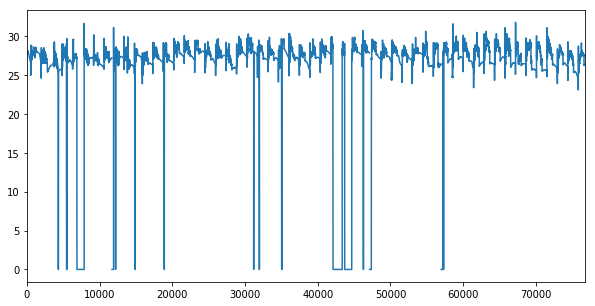

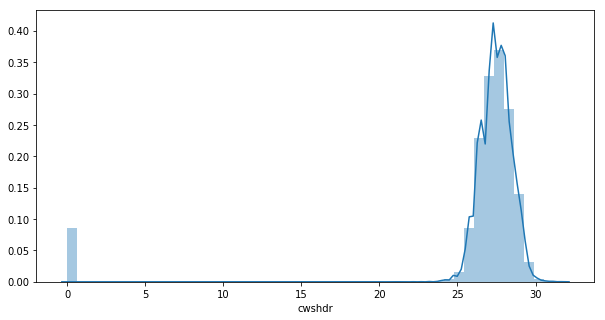

In [7]:
plt.figure(figsize=(10, 5))
sns.tsplot(sample.cwshdr, estimator=np.mean)

plt.figure(figsize=(10,5))
sns.distplot(sample.cwshdr.dropna())

We have many zeros because the chiller plant is probably shut down.

In [8]:
print(sample.cwshdr.isnull().sum())
print((sample.cwshdr == 0).sum(), (sample.cwshdr == 0).sum() / (sample.timestamp).count() * 100, "%")

66
4172 5.43547651619 %


## How to deal with null or zero values??

Zeros: We need to consider a sample interval between two zero regions (if zeros can be attributed to system shutdown). Otherwise, rolling average or *replicating trend of the previous day during that time* seems to make sense.

Nulls: Rolling average makes sense if there are not too many continuous values.

In [9]:
# take rolling average, with a window of 10 observations (10 mins)
roll_avg = sample.cwshdr.rolling(10, min_periods=1).mean()
roll_avg.isnull().sum(), (roll_avg == 0).sum()

(30, 0)

### Continuous nature of NaN values
Looks like we have to some something about this.. not simple rolling average will not solve.

https://pandas.pydata.org/pandas-docs/stable/missing_data.html

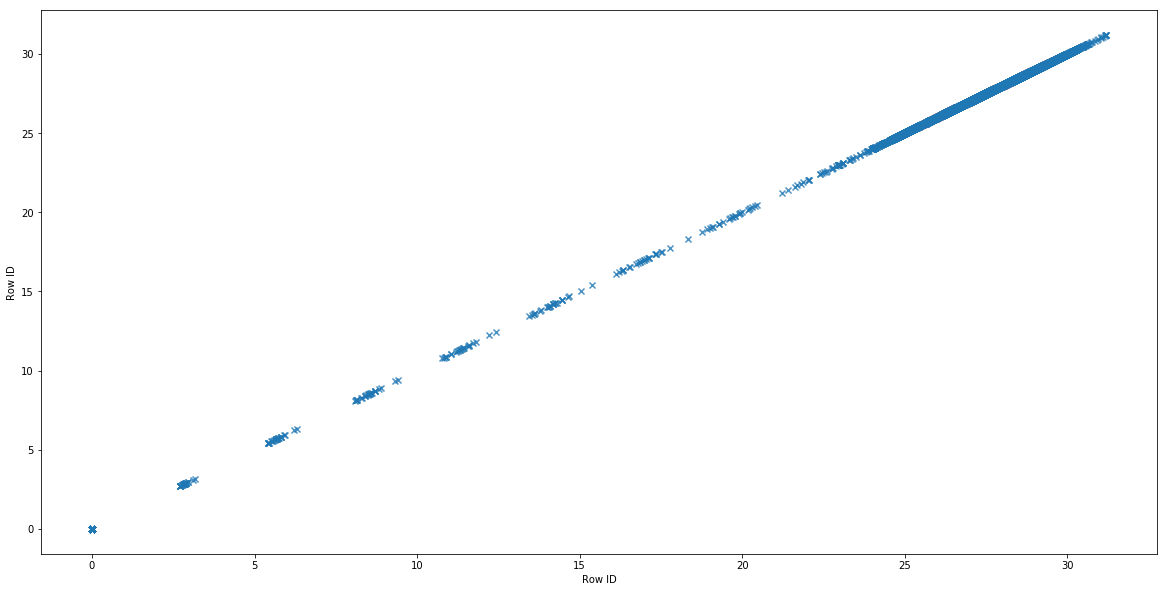

In [10]:
row_ids = sample[roll_avg.isnull()].row_id
plt.figure(figsize=(20, 10))
ax = sns.regplot(x=roll_avg, y=roll_avg, marker="x", fit_reg=False)
ax.set_xlabel("Row ID")
ax.set_ylabel("Row ID")

In [11]:
# replace null with rolling mean..
ts_data = sample.cwshdr.fillna(roll_avg)

## Looks like there are periodic trends above..

C:\Anaconda2\envs\py3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


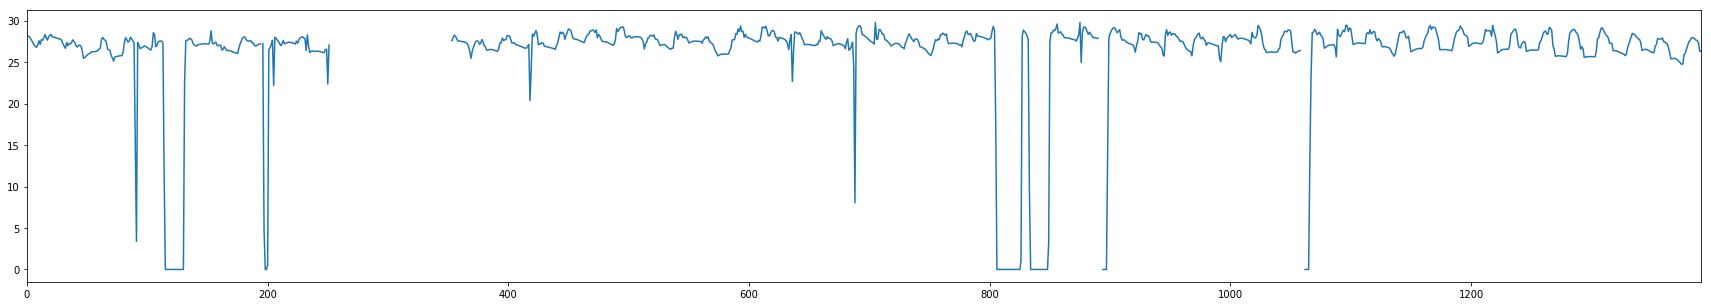

In [12]:
downsampled = ts_data.resample("1h").mean()
plt.figure(figsize=(30, 5))
sns.tsplot(downsampled, estimator=np.mean)

## Let's look at all of them together.. 

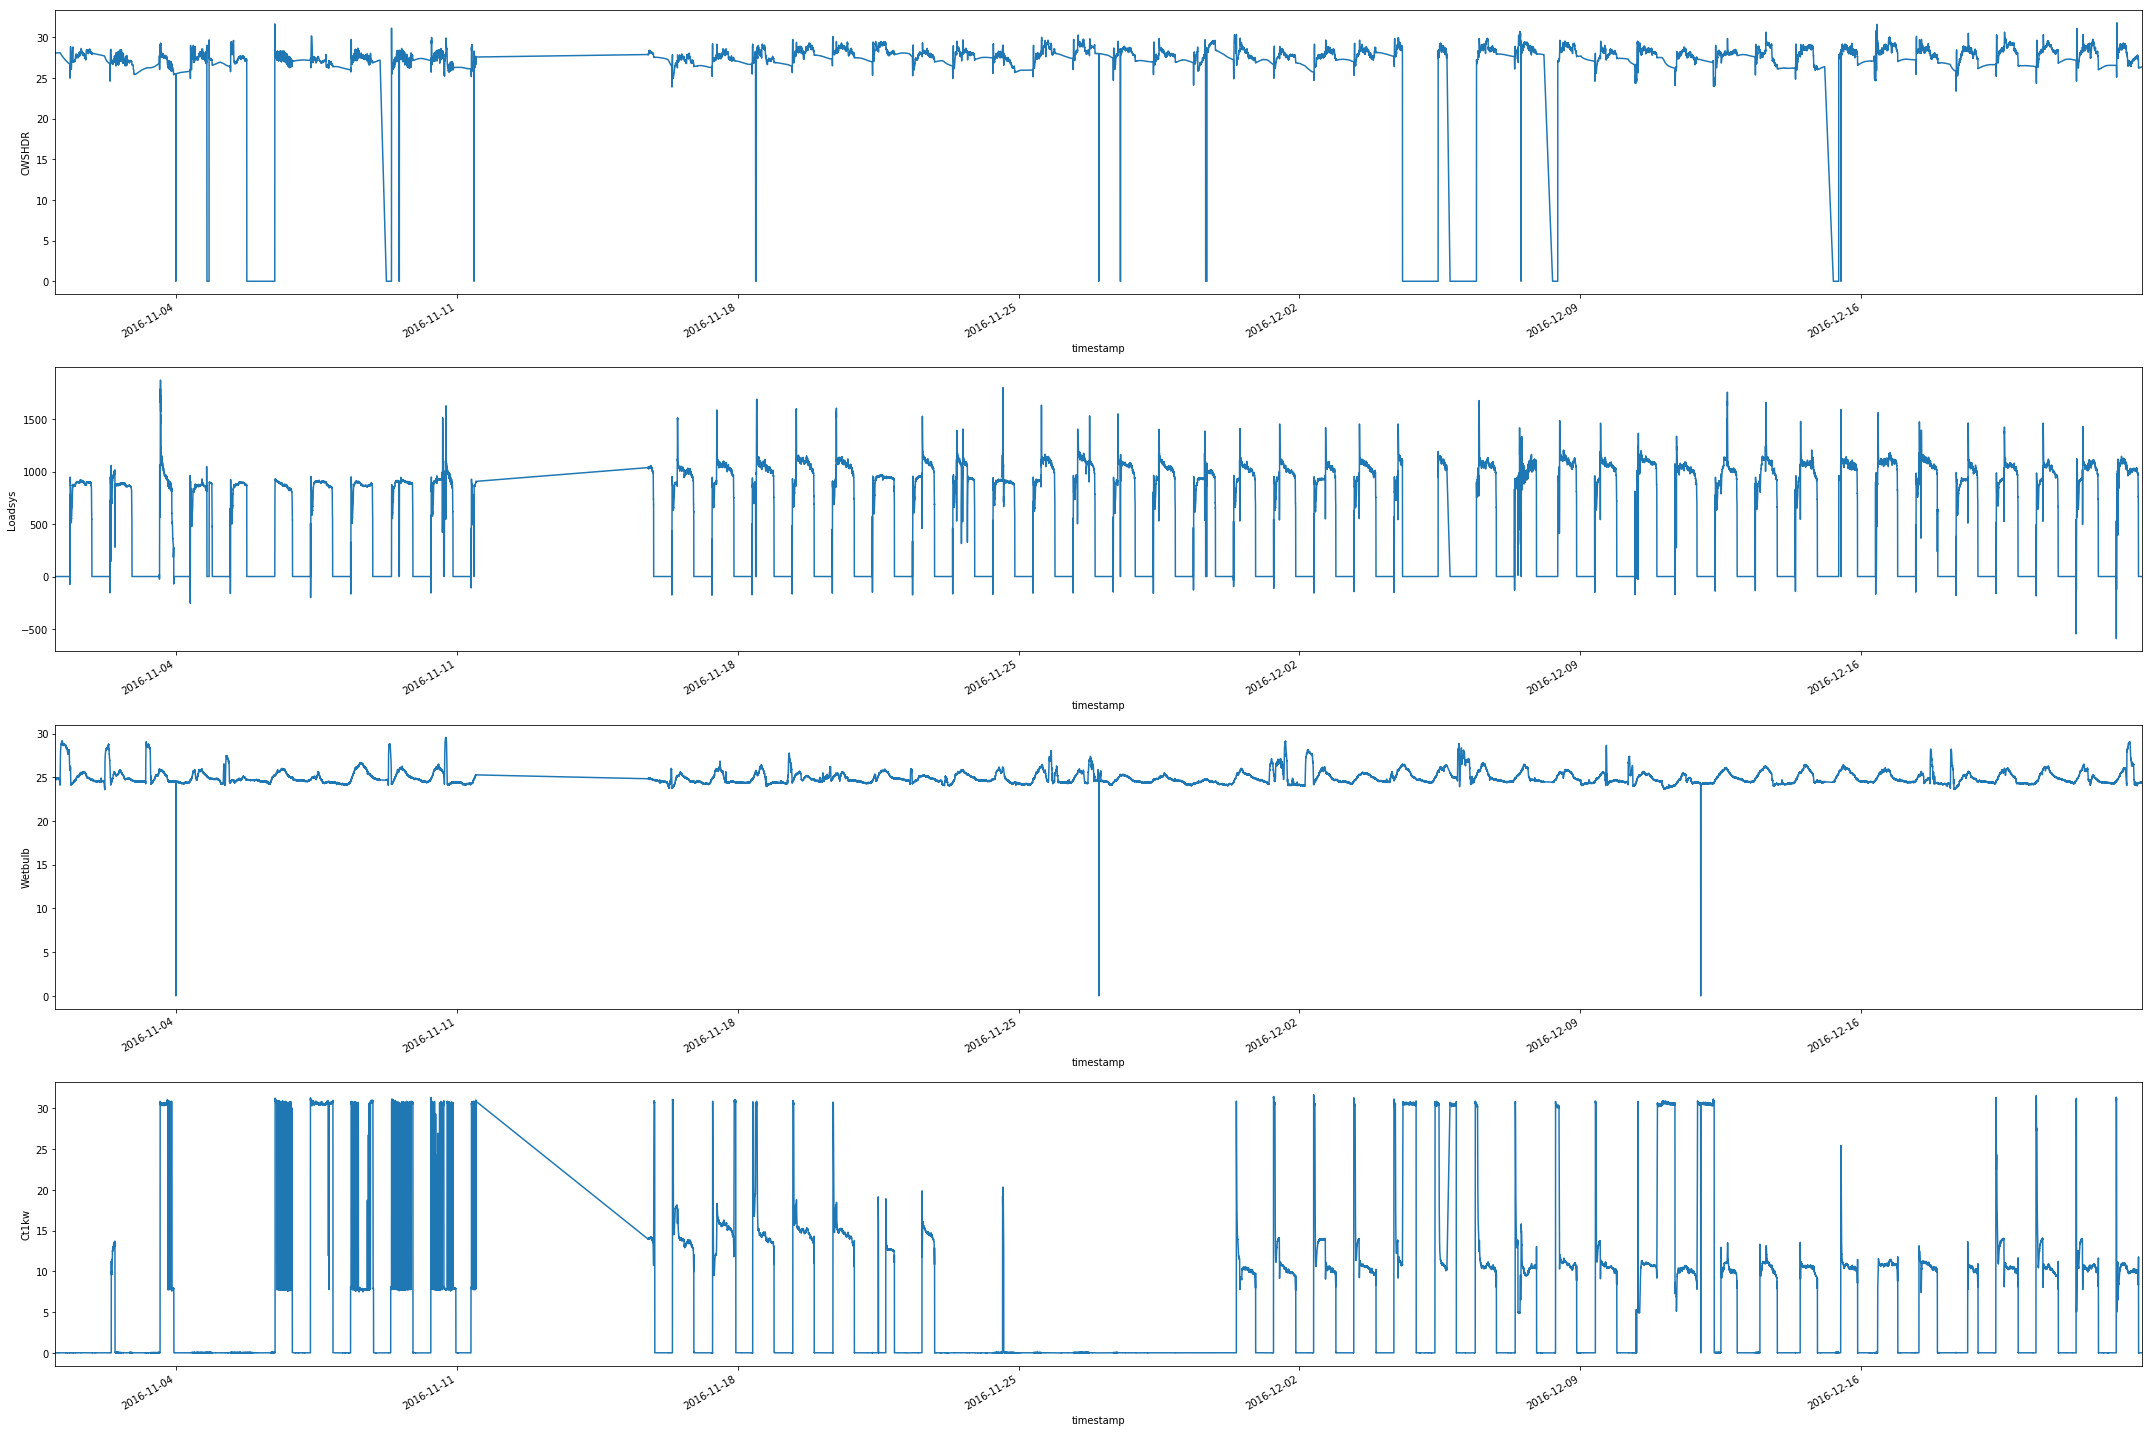

In [13]:
# Lets take one day's data and see how the characteristics vary
sample =  df["2016-11":"2016-12"]
sample = sample[ ["cwshdr", "loadsys", "wetbulb", "ct1kw", "ct2kw", "ct3kw"]].dropna()

f, (a1, a2, a3, a4) = plt.subplots(4, 1, figsize=(30,20))
sample.cwshdr.plot(ax=a1)
sample.loadsys.plot(ax=a2)
sample.wetbulb.plot(ax=a3)
sample.ct1kw.plot(ax=a4)


a1.set_ylabel("CWSHDR")
a2.set_ylabel("Loadsys")
a3.set_ylabel("Wetbulb")
a4.set_ylabel("Ct1kw")
f.tight_layout()

**Explanation for CWSHDR Trends**

- Everyday, from morning to afternoon, there is lot of activity in the building, hence increase in temperature
- Followed by, reduction until evening
- Followed by, slight increase from late evening to night
- Followed by, decrease from mid night to next morning

## Exploring further: Is this series stationary?

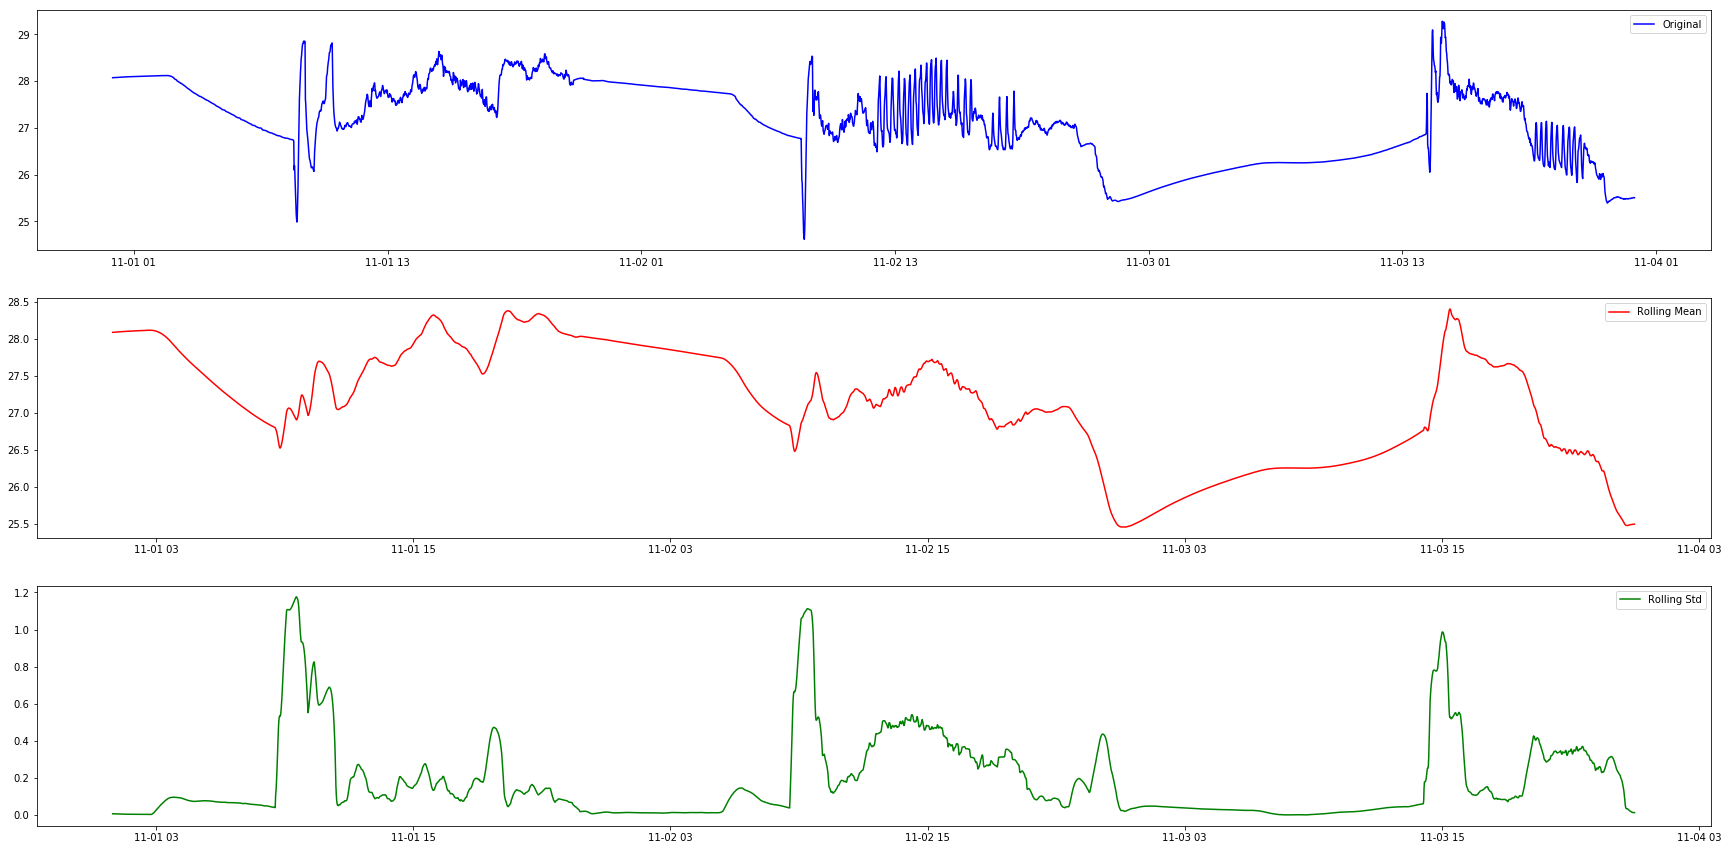

In [177]:
sample =  df["2016-11-01":"2016-11-03"] ### Change this to set the duration...
roll_mean = sample.cwshdr.rolling(60).mean() ### Window of 1hr length..
roll_std = sample.cwshdr.rolling(60).std()

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(30,15))
a1.plot(sample.cwshdr, color="b", label="Original"); a1.legend(loc="best")
a2.plot(roll_mean, color="r", label="Rolling Mean"); a2.legend(loc="best")
a3.plot(roll_std, color="g", label="Rolling Std"); a3.legend(loc="best")

In [178]:
from statsmodels.tsa.stattools import adfuller
adfout = adfuller(sample.cwshdr, autolag="AIC")
adfout_series = pd.Series(adfout[:4], index=["Statistic", "p-value", "#Lags used", "#Observations used"])
for k, v in adfout[4].items():
    adfout_series["Critical Value {}".format(k)] = v
adfout_series

Statistic               -2.231418
p-value                  0.195041
#Lags used              30.000000
#Observations used    4289.000000
Critical Value 1%       -3.431876
Critical Value 5%       -2.862214
Critical Value 10%      -2.567129
dtype: float64

## Let's down-sample
 
Check the Plots on **Tableau** identifying data points corresponding to these spikes

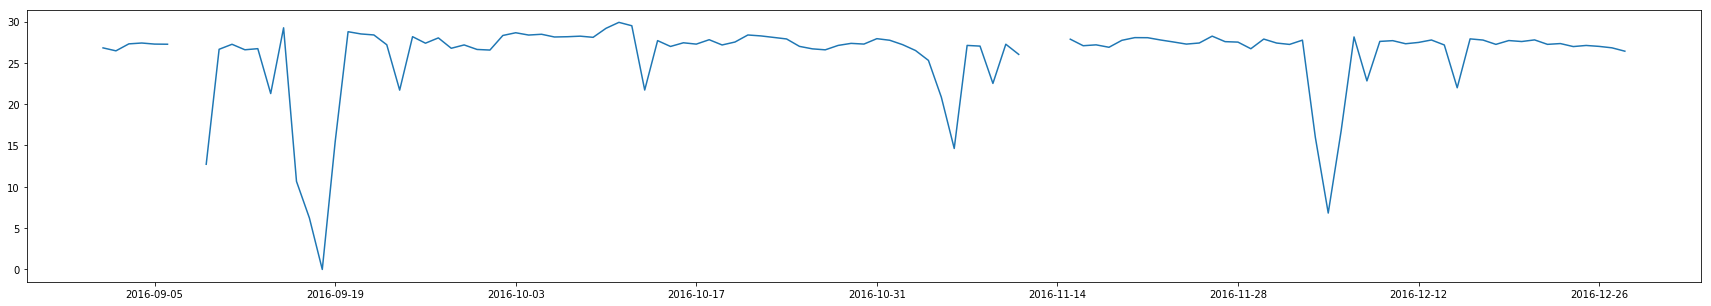

In [17]:
down_sampled = df["2016-09":"2016-12"].cwshdr.resample("1d").mean()
fig = plt.figure(figsize=(30,5))
plt.plot(down_sampled)

**Notes:**
Generally speaking, the mean is pretty much non-static. However, when we look with per-day sampling rate, its more close to stationary. As the CWSHDR rate per day could usually remain constant. There are spikes every month (check Tableau). These down-spikes seem to be periodic, attributing to system down time... But, otherwise, the mean looks pretty much stationary.

ADFuller Test confirms this. Statistic > Critical values. So, the time series is not stationary. 

**Few Observations on trends & seasonality**
- The mean per day is most likely remains constant. 
- There is a approx. seasonal trend with 1-day periodicity.


1. Mean per day seems to be approx constant (ignoring the spikes)

2. There is an approx. seasonal trend with 1-day periodicity on the original time series. This trend could be attributed to the usage of a chiller plant. Morning to Evening (usage increases). Evening to Late Evening (usage decreases). Late evening to night (usage increases). Mid night to next day morning (usage decreases).

3. The data points corresponding to down spikes observed with the 1day sampling rate may have interesting real-world relationship (**analysis on Tableau**). These spikes could be classified into 4 categories. 1) Large 2) Medium 3) Small 4) Very small depending on the value $X(t-1) - X(t)$ or $X(t+1) - X(t)$ is large / small
    
   - Small spikes are more frequent on Thursdays
   
   - Medium spikes are more frequent on Fridays. Other most frequent are Sundays and Mondays
   
   - Large spikes are present on Sundays and Mondays
   
   
So, Can we attribute these effects to system downtime or less activity?

## Modeling Trends and Seasonality

In [269]:
sample =  df["2016-10":"2016-10"]
sample = sample.fillna(method="ffill") # fill NaN values

(-0.07, 0.07)

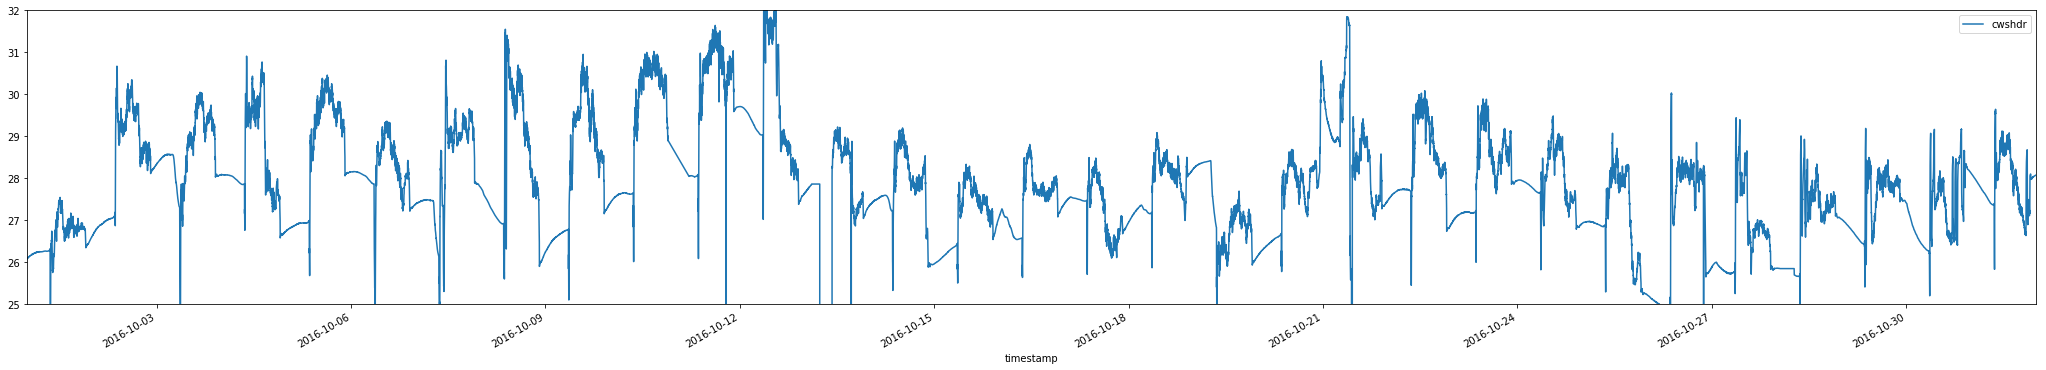

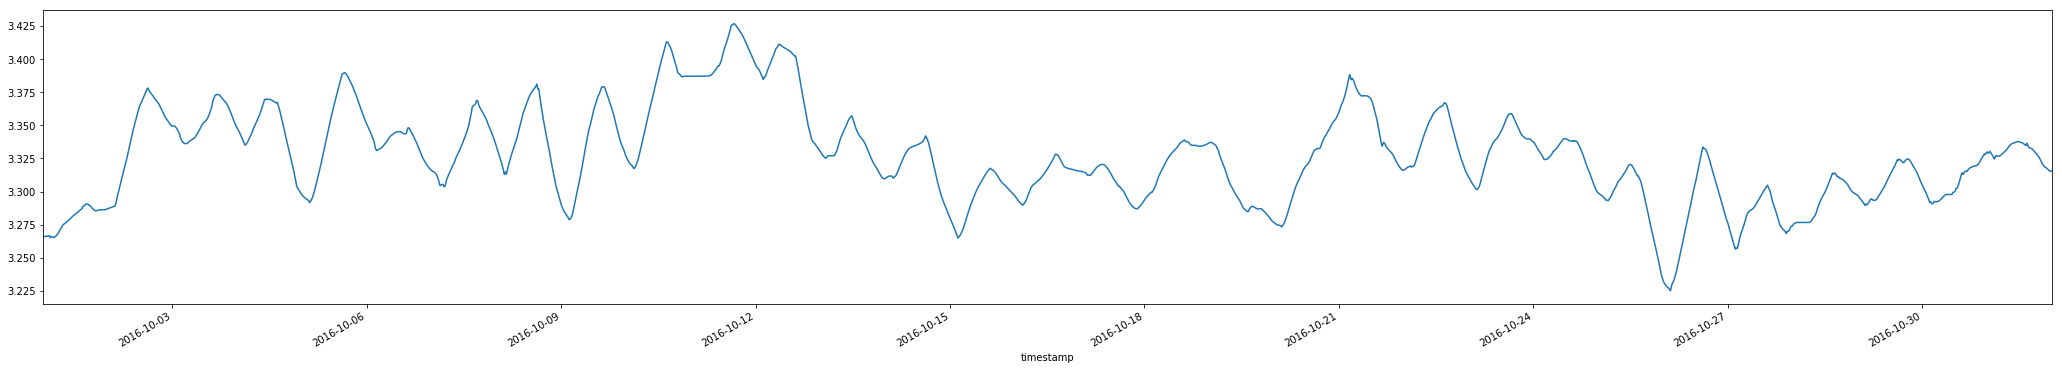

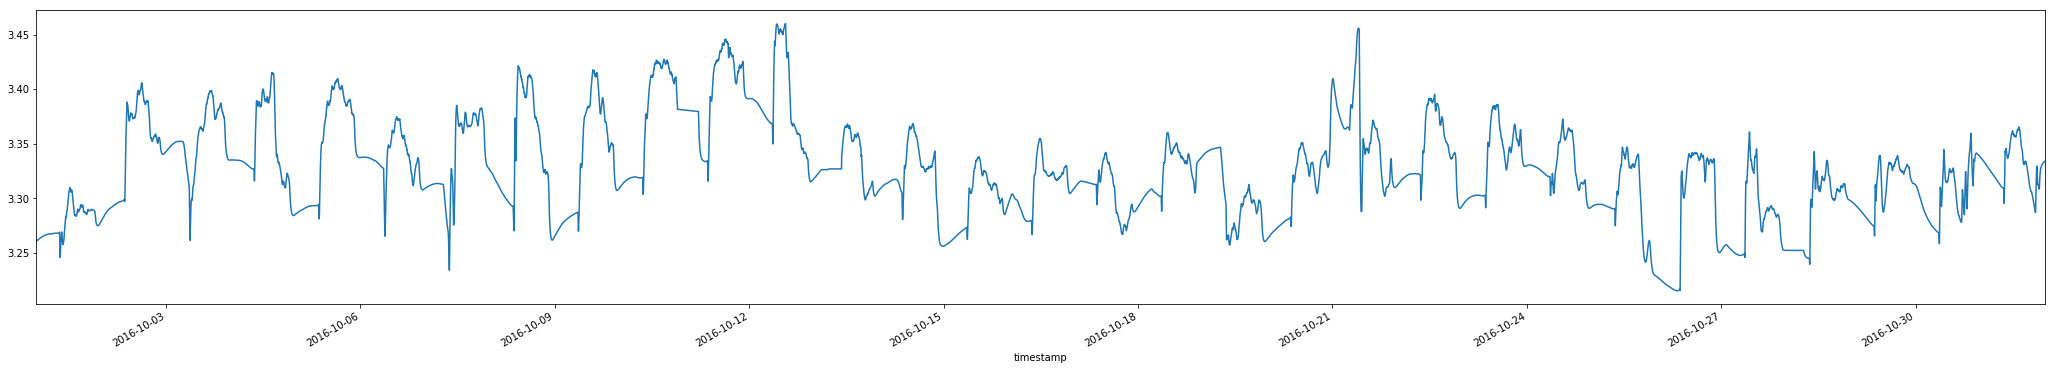

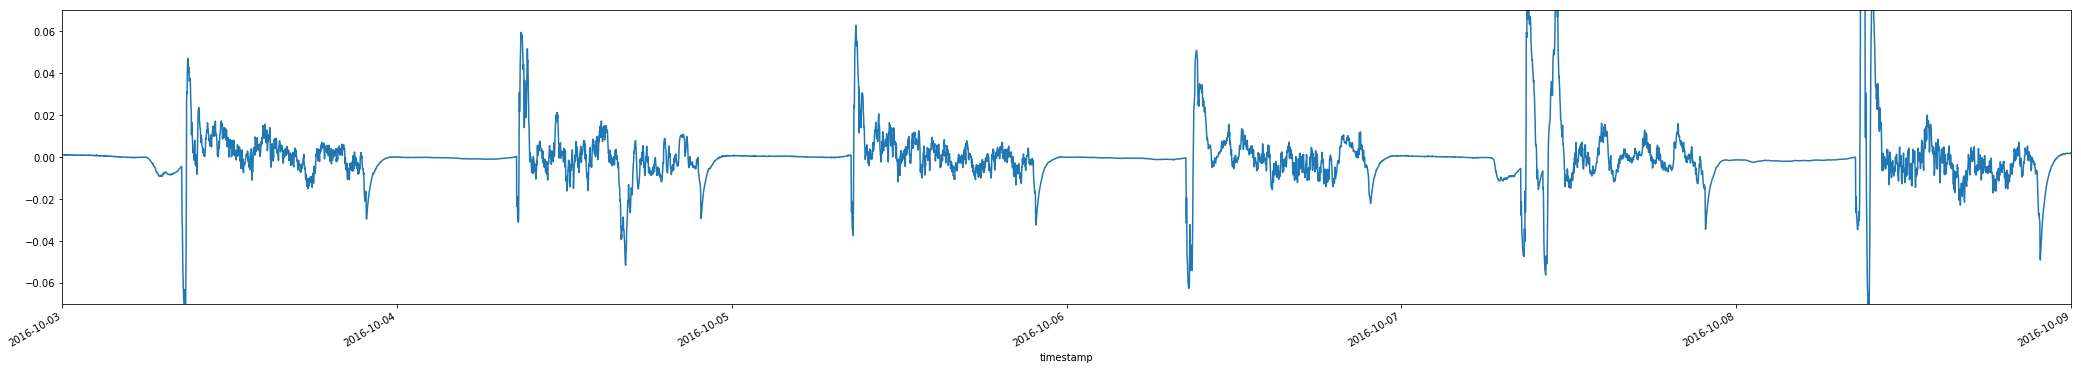

In [271]:
fig, a1 = plt.subplots(1, 1, figsize=(36,6))
sample.cwshdr.plot(ax=a1);a1.legend(loc="best"); a1.set_ylim(25, 32)

# sample -> log -> moving avg
# # 12 hrs window. 12hrs seems to be the periodicity in this time series..
data1 = sample.cwshdr.apply(np.log)
data2 = data1.rolling(12 * 60, min_periods=1, center=True).mean()
fig, a1 = plt.subplots(1, 1, figsize=(36,6))
data2.plot(ax=a1)

# sample -> log -> ewm
data3 = data1.ewm(halflife=2**4).mean()
fig, a1 = plt.subplots(1, 1, figsize=(36,6))
data3.plot(ax=a1)

# Log(sample) - EWM(Log(sample))
fig, a1 = plt.subplots(1, 1, figsize=(36,6))
data4 = data1-data3
data4.plot(ax=a1); a1.set_xlim("2016-10-03", "2016-10-09"); a1.set_ylim(-0.07, 0.07)

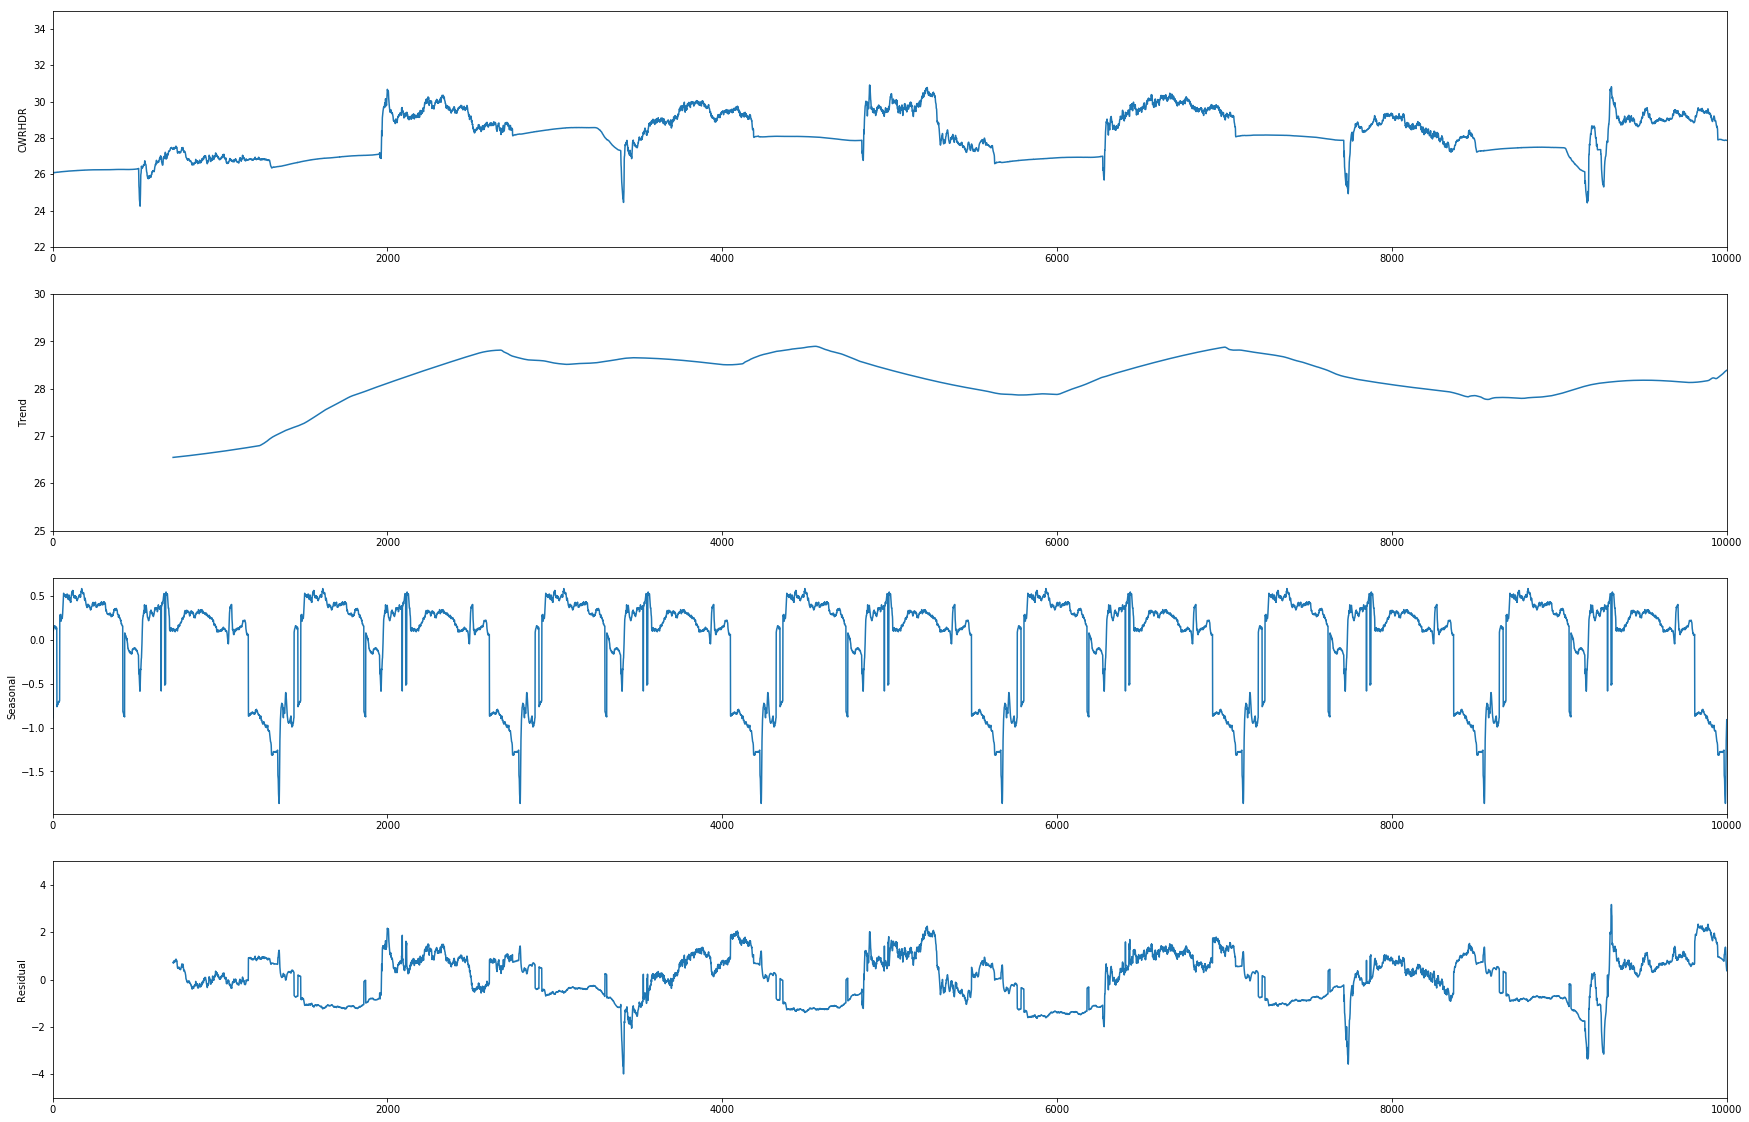

In [281]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(sample.cwshdr.values, freq=24 * 60)
fig, (a1,a2,a3,a4) = plt.subplots(4, 1, figsize=(30, 20))
a1.plot(sample.cwshdr.values)
a2.plot(decomposed.trend)
a3.plot(decomposed.seasonal)
a4.plot(decomposed.resid)

a1.set_xlim(0, 10000); a1.set_ylabel("CWRHDR"); a1.set_ylim(22, 35);
a2.set_xlim(0, 10000); a2.set_ylabel("Trend"); a2.set_ylim(25, 30);
a3.set_xlim(0, 10000); a3.set_ylabel("Seasonal");
a4.set_xlim(0, 10000); a4.set_ylabel("Residual"); a4.set_ylim(-5,5);

## Forecasting with ARIMA

In [292]:
resid = [i for i in decomposed.resid if not np.isnan(i)]